<a href="https://colab.research.google.com/github/sahil3Vedi/Face-Generator/blob/master/Conditional_StyleGAN_I.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade tqdm

Requirement already up-to-date: tqdm in /usr/local/lib/python3.6/dist-packages (4.46.0)


In [0]:
import os 

In [3]:
!rm -rf sample_data
!git clone https://github.com/pbaylies/stylegan-encoder

Cloning into 'stylegan-encoder'...
remote: Enumerating objects: 483, done.
remote: Total 483 (delta 0), reused 0 (delta 0), pack-reused 483
Receiving objects: 100% (483/483), 12.75 MiB | 26.80 MiB/s, done.
Resolving deltas: 100% (264/264), done.


In [0]:
!cd stylegan-encoder
!rm -rf aligned_images raw_images
!mkdir aligned_images raw_images

In [7]:
cd stylegan-encoder

/content/stylegan-encoder


Found 3 images in raw_images
['Obama.jpg', 'Obama2.jpg', 'Obama3.jpg']


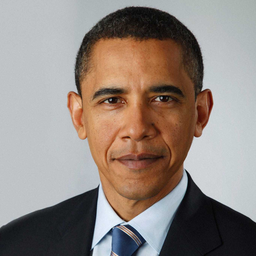

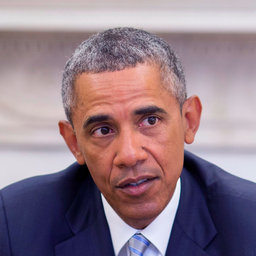

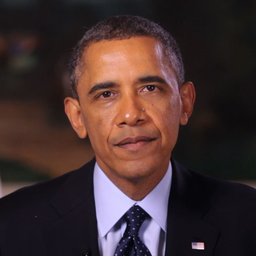

In [9]:
from PIL import Image
import os
imgs = sorted(os.listdir('raw_images'))

print("Found %d images in %s" %(len(imgs), 'raw_images'))
if len(imgs) == 0:
  print("Upload images to the \"raw_images\" folder!")
else:
  print(imgs)

for img_path in imgs:
  img = Image.open('raw_images/' + img_path)
  
  w,h = img.size
  rescale_ratio = 256 / min(w,h)
  img = img.resize((int(rescale_ratio*w),int(rescale_ratio*h)), Image.LANCZOS)
  display(img)

In [10]:
#Checking Tensorflow Version (1.x)

%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


In [11]:
# Aligning Faces

!python align_images.py raw_images/ aligned_images/ --output_size=1024

Using TensorFlow backend.
64045056/64040097 [==============================] - 2s 0us/step
Aligning Obama2.jpg ...
Getting landmarks...
Starting face alignment...
Wrote result aligned_images/Obama2_01.png
Aligning Obama3.jpg ...
Getting landmarks...
Starting face alignment...
Wrote result aligned_images/Obama3_01.png
Aligning Obama.jpg ...
Getting landmarks...
Starting face alignment...
Wrote result aligned_images/Obama_01.png


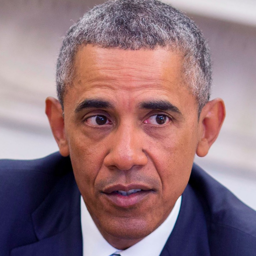

'img 0: Obama2_01.png'

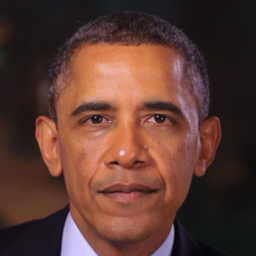

'img 1: Obama3_01.png'

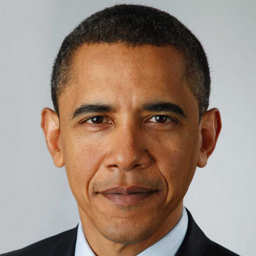

'img 2: Obama_01.png'

In [12]:
def display_folder_content(folder, res = 256):
  if folder[-1] != '/': folder += '/'
  for i, img_path in enumerate(sorted(os.listdir(folder))):
    if '.png' in img_path:
      display(Image.open(folder+img_path).resize((res,res)), 'img %d: %s' %(i, img_path))
      print('\n')
      
display_folder_content('aligned_images')

In [13]:
!gdown https://drive.google.com/uc?id=1aT59NFy9-bNyXjDuZOTMl0qX0jmZc6Zb
!mkdir data
!mv finetuned_resnet.h5 data
!rm -rf generated_images latent_representations

Downloading...
From: https://drive.google.com/uc?id=1aT59NFy9-bNyXjDuZOTMl0qX0jmZc6Zb
To: /content/stylegan-encoder/finetuned_resnet.h5
330MB [00:21, 15.6MB/s]


In [14]:
print("aligned_images contains %d images ready for encoding!" %len(os.listdir('aligned_images/')))
print("Recommended batch_size for the encode_images process: %d" %min(len(os.listdir('aligned_images/')), 8))

aligned_images contains 3 images ready for encoding!
Recommended batch_size for the encode_images process: 3


In [22]:
!python encode_images.py --optimizer=adam --lr=0.02 --decay_rate=0.95 --decay_steps=6 --use_l1_penalty=0.3 --face_mask=True --iterations=400 --early_stopping=True --early_stopping_threshold=0.05 --average_best_loss=0.5 --use_lpips_loss=0 --use_discriminator_loss=0 --output_video=True aligned_images/ generated_images/ latent_representations/
print("\n************ Latent code optimization finished! ***************")




Using TensorFlow backend.










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




Instructions for updating:
If using Keras pass *_constraint arguments to layers.

58892288/58889256 [==============================] - 1s 0us/step
  0% 0/1 [00:00<?, ?it/s]WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:431: The name tf.is_variable_initialized is deprecated. Please use tf.compat.v1.is_variable_initialized instead.


Saving mask masks/Obama2_01.png
Saving mask masks/Obama3_01.png
Saving mask masks/Obama_01.png
Loading ResNet Model:

  0% 0/400 [00:00<?, ?it/s]WARNING:tensorflow:From /content/stylegan-encoder/encoder/perceptual_model.py:292: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().

Obama2_01 Obama3_01 Obama_01: